In [11]:
#imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import graphviz

In [12]:
data = pd.read_csv('MNIST.csv')
data = np.array(data)
np.random.shuffle(data)

In [13]:
m, n = data.shape

data_test = data[0:1000].T
Y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255

_, m_train = X_train.shape

In [14]:
data_train.shape

(785, 41000)

In [15]:
class PReLU:
    def __init__(self, alpha_init = 0.01):
        self.alpha = alpha_init

    def forward(self, Z):
        return np.maximum(self.alpha * Z, Z)

    def prime(self, Z):
        return np.where(Z > 0, 1, self.alpha)

def update_alpha(alpha, dZ):
    learning_rate = 0.01
    alpha -= learning_rate * np.mean(np.where(dZ < 0, dZ * alpha, 0))
    return alpha

prelu_1 = PReLU()
prelu_2 = PReLU()



def ReLU(Z):
    return np.maximum(Z, 0)

def ReLU_prime(Z):
    return Z > 0



def sigmoid(Z):
    A = 1 / (1 + np.exp(np.clip(-Z, -4, 4)))
    return A

def sigmoid_prime(Z):
    A = (sigmoid(Z) * (1 - sigmoid(Z)))
    return A



def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A



def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [16]:
def init_params(input, hidden_1, hidden_2, output, bias = 1):
    W1 = np.random.rand(hidden_1, input) - 0.5
    b1 = np.random.rand(hidden_1, bias) - 0.5

    W2 = np.random.rand(hidden_2, hidden_1) - 0.5
    b2 = np.random.rand(hidden_2, bias) - 0.5

    W3 = np.random.rand(output, hidden_2) - 0.5
    b3 = np.random.rand(output, bias) - 0.5
    return W1, b1, W2, b2, W3, b3

def forward_prop(W1, b1, W2, b2, W3, b3, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)

    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)

    Z3 = W3.dot(A2)
    A3 = softmax(Z3)

    return Z1, A1, Z2, A2, Z3, A3

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y):
    one_hot_Y = one_hot(Y)

    dZ3 = A3 - one_hot_Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3, axis = 1, keepdims = True)

    dZ2 = W3.T.dot(dZ3) * ReLU_prime(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis = 1, keepdims = True)

    dZ1 = W2.T.dot(dZ2) * ReLU_prime(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis = 1, keepdims = True)

    # prelu_1.alpha = update_alpha(prelu_1.alpha, dZ1)
    # prelu_2.alpha = update_alpha(prelu_2.alpha, dZ1)
    
    return dW1, db1, dW2, db2, dW3, db3

In [17]:
#Training algs

def gradient_descent(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1

    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2

    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3

    return W1, b1, W2, b2, W3, b3

In [18]:
def make_predictions(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
    predictions = get_predictions(A3)
    confidence = np.max(softmax(Z3), axis = 0)
    return predictions, confidence

def test_results(idx, W1, b1, W2, b2, W3, b3):
    curr_img = X_train[:, idx, None]
    prediction, confidence = make_predictions(X_train[:, idx, None], W1, b1, W2, b2, W3, b3)
    label = Y_train[idx]

    print('Prediction:', prediction)
    print('actual:', label)
    print('confidence:', confidence)

    curr_img = curr_img.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(curr_img)
    plt.show()

In [19]:
def get_predictions(A3):
    return np.argmax(A3, 0)

def get_accuracy(predictions, Y):
    return round((np.sum(predictions == Y) / Y.size) * 100, 2)

def train(X, Y, epochs, alpha):
    W1, b1, W2, b2, W3, b3 = init_params(784, 64, 32, 10) #ONLY CHANGE HIDDEN LAYERS!!!!

    for e in range(epochs):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y)
        W1, b1, W2, b2, W3, b3 = gradient_descent(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)

        if e % 50 == 0:
            print("Epoch:", e)
            print("Accuracy:", get_accuracy(get_predictions(A3), Y), "%")

    print("Epoch:", e)
    print("Accuracy:", get_accuracy(get_predictions(A3), Y), "%")

    return W1, b1, W2, b2, W3, b3

def continue_train(X, Y, epochs, alpha, W1, b1, W2, b2, W3, b3):

    for e in range(epochs):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y)
        W1, b1, W2, b2, W3, b3 = gradient_descent(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)

        if e % 50 == 0:
            print("Epoch:", e)
            print("Accuracy:", get_accuracy(get_predictions(A3), Y), "%")

    print("Epoch:", e)
    print("Accuracy:", get_accuracy(get_predictions(A3), Y), "%")

    return W1, b1, W2, b2, W3, b3

In [20]:
W1, b1, W2, b2, W3, b3 = train(X_train, Y_train, 1000, 0.1)

Epoch: 0
Accuracy: 6.67 %
Epoch: 50
Accuracy: 69.88 %
Epoch: 100
Accuracy: 78.39 %
Epoch: 150
Accuracy: 82.07 %
Epoch: 200
Accuracy: 84.41 %
Epoch: 250
Accuracy: 86.03 %
Epoch: 300
Accuracy: 87.19 %
Epoch: 350
Accuracy: 88.07 %
Epoch: 400
Accuracy: 88.71 %
Epoch: 450
Accuracy: 89.24 %
Epoch: 500
Accuracy: 89.78 %
Epoch: 550
Accuracy: 90.22 %
Epoch: 600
Accuracy: 90.57 %
Epoch: 650
Accuracy: 90.89 %
Epoch: 700
Accuracy: 91.15 %
Epoch: 750
Accuracy: 91.41 %
Epoch: 800
Accuracy: 91.66 %
Epoch: 850
Accuracy: 91.89 %
Epoch: 900
Accuracy: 92.07 %
Epoch: 950
Accuracy: 92.25 %
Epoch: 999
Accuracy: 92.42 %


Prediction: [0]
actual: 0
confidence: [0.99999222]


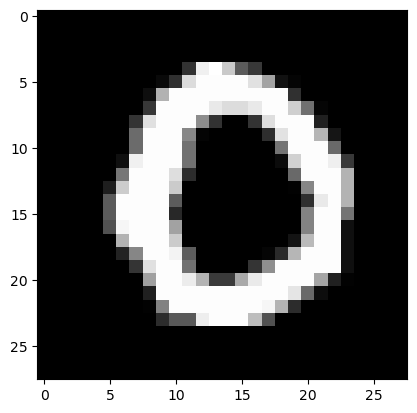

In [24]:
test_results(np.random.randint(0, Y_train.size), W1, b1, W2, b2, W3, b3)

In [28]:
test_predictions = make_predictions(X_test, W1, b1, W2, b2, W3, b3)
get_accuracy(test_predictions, Y_test)

94.5

In [29]:
W1, b1, W2, b2, W3, b3 = continue_train(X_train, Y_train, 10000, 0.01, W1, b1, W2, b2, W3, b3)

Epoch: 0
Accuracy: 94.6 %
Epoch: 50
Accuracy: 94.6 %
Epoch: 100
Accuracy: 94.61 %
Epoch: 150
Accuracy: 94.62 %
Epoch: 200
Accuracy: 94.63 %
Epoch: 250
Accuracy: 94.64 %
Epoch: 300
Accuracy: 94.66 %
Epoch: 350
Accuracy: 94.66 %
Epoch: 400
Accuracy: 94.66 %
Epoch: 450
Accuracy: 94.67 %
Epoch: 500
Accuracy: 94.68 %
Epoch: 550
Accuracy: 94.68 %
Epoch: 600
Accuracy: 94.69 %
Epoch: 650
Accuracy: 94.7 %
Epoch: 700
Accuracy: 94.72 %
Epoch: 750
Accuracy: 94.72 %
Epoch: 800
Accuracy: 94.73 %
Epoch: 850
Accuracy: 94.74 %
Epoch: 900
Accuracy: 94.76 %
Epoch: 950
Accuracy: 94.76 %
Epoch: 1000
Accuracy: 94.77 %
Epoch: 1050
Accuracy: 94.77 %
Epoch: 1100
Accuracy: 94.78 %
Epoch: 1150
Accuracy: 94.78 %
Epoch: 1200
Accuracy: 94.79 %
Epoch: 1250
Accuracy: 94.79 %
Epoch: 1300
Accuracy: 94.79 %
Epoch: 1350
Accuracy: 94.8 %
Epoch: 1400
Accuracy: 94.81 %
Epoch: 1450
Accuracy: 94.81 %
Epoch: 1500
Accuracy: 94.81 %
Epoch: 1550
Accuracy: 94.82 %
Epoch: 1600
Accuracy: 94.83 %
Epoch: 1650
Accuracy: 94.83 %
Epoch: 